In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from pydataset import data
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from env import get_db_url
import acquire
import prepare
from prepare import percentage_stacked_plot
import warnings
warnings.filterwarnings("ignore")

# Project Overview and Goals

The goal of this project is to find the key drivers of property tax value for single family properties that had a transaction in 2017. The scenario is that a Zillow Data Science Team has a model ready, but they are looking for insights that can help improve it. This project will give recommendations on a way to make a better model. It will also give me an opportunity to practice the data science pipeline to include Acquire, Prepare, Exploring, and Modeling.

- Construct an ML Regression model that predict propery tax assessed values ('taxvaluedollarcnt') of Single Family Properties using attributes of the properties.

- Find the key drivers of property value for single family properties. 

- Deliver a report that the data science team can read through and replicate, understand what steps were taken, why and what the outcome was.

- Make recommendations on what works or doesn't work in prediction these homes' values.

# Data Acquisition

In [2]:
# acquires data from acquire.py file
df = acquire.get_zillow_data()
df.head()

,bedrooms,bathrooms,square_feet,lot_size,pool,zip_code,year_built,latitude,longitude,fips,tax_value,tax_amount,transaction_date,log_error
0,4.0,2.0,3633.0,9826.0,NaN,97329.0,2005.0,34560018.0,-118169806.0,6037.0,296425.0,6941.39,2017-01-02,0.042463
1,3.0,4.0,1620.0,NaN,NaN,96047.0,2011.0,33996200.0,-118438000.0,6037.0,847770.0,10244.94,2017-01-02,-0.019546
2,3.0,2.0,2077.0,6490.0,NaN,96152.0,1926.0,34012977.0,-118479243.0,6037.0,646760.0,7924.68,2017-01-02,-0.040807
3,3.0,1.0,1244.0,6021.0,NaN,96201.0,1950.0,33953559.0,-118083855.0,6037.0,169471.0,2532.88,2017-01-03,0.042412
4,3.0,2.0,1300.0,4917.0,NaN,96193.0,1950.0,33897134.0,-118102953.0,6037.0,233266.0,3110.99,2017-01-03,-0.000908


# Data Preparation 

In [3]:
# prepares data from prepare.py file
df = prepare.prep_zillow(df)
df.head()

,bedrooms,bathrooms,square_feet,lot_size,pool,zip_code,year_built,latitude,longitude,fips,tax_value,tax_amount,transaction_date,log_error,transaction_month,county,tax_rate
5,3,2.0,1222,5500,1,96193,1951,33889894.0,-118100732.0,6037,290492,3870,2017-01-03,-0.316484,1,Los Angeles,1.332223
38,4,2.5,1620,8531,1,97099,1967,34440918.0,-119293909.0,6111,369463,4585,2017-01-03,0.102849,1,Ventura,1.240990
40,4,4.0,2840,60548,1,97099,1966,34452715.0,-119266845.0,6111,610795,6970,2017-01-03,-0.069136,1,Ventura,1.141136
54,3,2.0,1638,197651,1,97099,1989,34454777.0,-119197226.0,6111,653582,6997,2017-01-03,-0.010887,1,Ventura,1.070562
58,3,2.0,1583,8000,1,97099,1961,34419017.0,-119296402.0,6111,465462,5644,2017-01-03,0.052558,1,Ventura,1.212559


### Note: DF only contains bathrooms/bathrooms with <= 6, square_feet <= 3000, and tax_value <= 1000000 because this accounted for ~94% of the data I wanted to target.

In [4]:
# splits my data
train_validate, test = train_test_split(df, test_size = 0.10, random_state = 123)
train, validate = train_test_split(train_validate, test_size = 0.20, random_state = 123)
print(train.shape, validate.shape, test.shape)

(5652, 17) (1413, 17) (785, 17)


# Data Exploration

## Initial questions, thoughts, and comments:

- Why do some properties have a much higher value than others when they are located so close to each other? 
    - perhaps determining the month in which people are more likely to purchase the tax rates increase.
    

- Why are some properties valued so differently from others when they have nearly the same physical attributes but only differ in location? 
    - since the location of homes is in three CA Counties, perhaps being closer to the ocean drives total tax assessed value.
    

- Is having different combinations of bedrooms and baths a key driver? What about the size of the property?

    - I think size or features of a home definitely plays a role in tax value which includes:
        - bedrooms
        - bathrooms
        - square_feet
        - lot_size


### Hypothesis on Month of transaction
    - Is the mean of transactions for entire population of homes equal to the mean of transactions by month?

- $H_0$  Mean of transactions in entire population = Mean of transactions in May
- $H_a$  Mean of transactions in entire population != Mean of transactions in May

### Visualizations of transactions by month and density of total tax assessed values

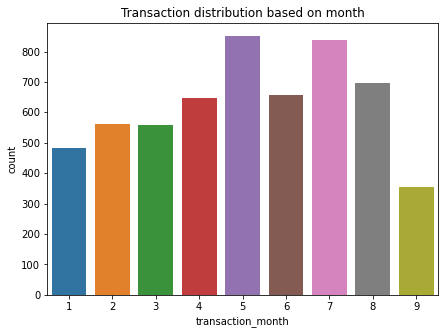

In [5]:
#Temporal data distribution of transaction_month, function created in prepare.py
plt.figure(figsize=(7,5))
sns.countplot(x=train.transaction_month).set_title("Transaction distribution based on month");

Text(0.5, 1.0, 'Total tax assessed value by Month')

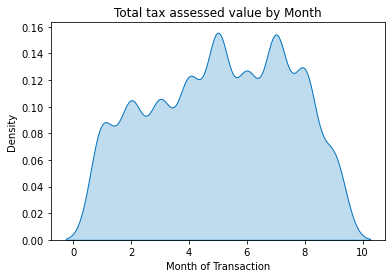

In [6]:
Mth = sns.kdeplot(train.transaction_month[(train["tax_value"] < 1000000) ],
                color="#0072BD", shade = True)
Mth.set_ylabel('Density')
Mth.set_xlabel('Month of Transaction')
Mth.set_title('Total tax assessed value by Month')

### Testing on Month of transaction

In [7]:
# sets alpha and performs One-Sample T-Test
alpha = .05
transaction_sample = df[df.tax_value < 1000000].transaction_month
overall_mean = df.transaction_month.mean()

t, p = stats.ttest_1samp(transaction_sample, overall_mean)

print(t, p/2, alpha)

0.0003608407646743951 0.4998560499512411 0.05


In [8]:
# code for t-test
t, p = stats.ttest_1samp(transaction_sample, overall_mean)
t, p

(0.0003608407646743951, 0.9997120999024822)

In [9]:
# Is 1/2 of p-value < alpha AND t-stat < 0?
print(t < 0)
print(p/2 < alpha)

False
False


In [10]:
# prints hypothesis null or alternate
if p/2 > alpha:
    print("We fail to reject null hypothesis")
elif t < 0:
    print("We fail to reject null hypothesis")
else:
    print("We reject null hypothesis")

We fail to reject null hypothesis


- p-value: 1.0

### Hypothesis on location
    - Is the tax value higher by county?

- $H_0$ : There is no association between location and tax value.
- $H_a$ : There is an association between location and tax value.

### Visualizations on location and hypothesis testing

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

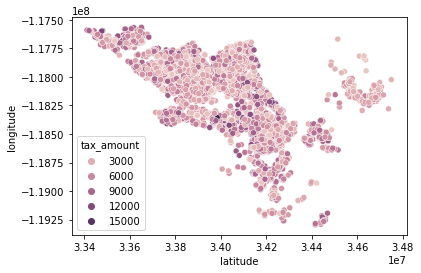

In [11]:
# Plots lats/longs by tax amount
sns.scatterplot(x=train.latitude , y=train.longitude, hue=train.tax_amount)

### dificult to determine relation using scatterplot. Appears evenly distributed.

<AxesSubplot:xlabel='county', ylabel='tax_value'>

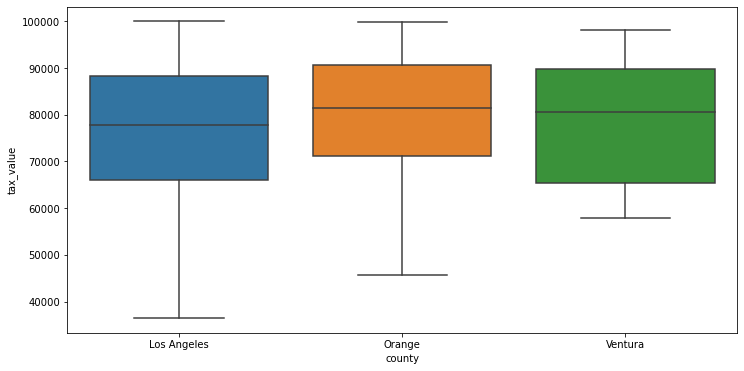

In [12]:
# boxplot showing tax value by county
plt.figure(figsize=(12,6))
sns.boxplot(x= train[train.tax_value<1000000].county, 
            y= train[train.tax_value<100000].tax_value, data=train[train.tax_value<100000])

#### Note: Highest total tax assessed value is in Orange County

### Testing on Location

In [13]:
# code to run chi square test

observed = pd.crosstab(train.tax_value, train.county)
chi2, p, degf, expected = stats.chi2_contingency(observed)
print('Observed\n')
print(observed)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")

Observed

county     Los Angeles  Orange  Ventura
tax_value                              
36494                1       0        0
40964                1       0        0
44627                1       0        0
45271                1       0        0
45647                0       1        0
...                ...     ...      ...
994996               1       0        0
995503               1       0        0
998838               1       0        0
999290               1       0        0
1000000              1       0        0

[5363 rows x 3 columns]
---
Expected

[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
---

chi^2 = 10842.7254
p     = 0.2083
We fail to reject the null hypothesis.


### Hypothesis relationship between bedrooms, bathrooms, square_feet, and lot_size
    - Is there a relationship between tax values and the above features?

- $H_0$: There is no relationship between tax values and number of bedrooms, bathrooms and square_feet.
- $H_a$: There is a relationship between tax values and number of bedrooms, bathrooms and square_feet

#### Note: I will create a subset df with these specific features to determine correlation to tax value

In [14]:
#creates a subset df with specific and continuous variables to create heatmap
train_corr = train[['bathrooms', 'bedrooms', 'square_feet', 'lot_size', 'tax_value']]

In [15]:
# using corr() function to find correlation between columns
train_corr = train_corr.corr()
train_corr

,bathrooms,bedrooms,square_feet,lot_size,tax_value
bathrooms,1.000000,0.474357,0.707201,0.082465,0.270707
bedrooms,0.474357,1.000000,0.508887,-0.018564,0.108301
square_feet,0.707201,0.508887,1.000000,0.128391,0.374145
lot_size,0.082465,-0.018564,0.128391,1.000000,0.051627
tax_value,0.270707,0.108301,0.374145,0.051627,1.000000


### Visualizations on selected features (bathrooms, bedrooms, square_feet, lot_size) in relation to tax value

<AxesSubplot:>

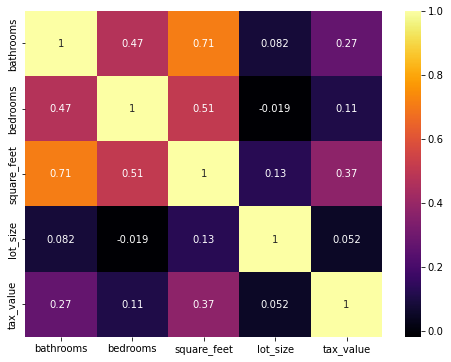

In [16]:
# plots heatmap and correlation values 
plt.figure(figsize=(8,6))
sns.heatmap(train_corr, annot=True, cmap='inferno')

### Note: Highest correlation in order is square_feet (0.37), bathrooms (0.27), bedrooms (0.11), and lastly lot_size (0.052).
    - strange to find out that bathrooms is higher than bedrooms.
    - also strange that lot_size is the least correlated. (perhaps with extra time can do some feature engineering to find out what impacts that)

Text(0.5, 1.0, 'Total tax assessed value by Bedrooms')

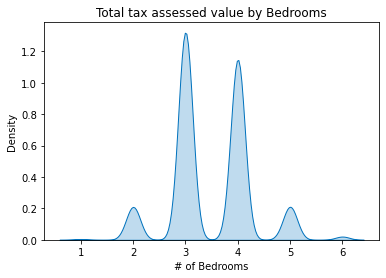

In [17]:
Mth = sns.kdeplot(train.bedrooms[(train["tax_value"] < 1000000) ],
                color="#0072BD", shade = True)
Mth.set_ylabel('Density')
Mth.set_xlabel('# of Bedrooms')
Mth.set_title('Total tax assessed value by Bedrooms')

#### Note: 3 and 4 bedrooms have highest tax value.

Text(0.5, 1.0, 'Total tax assessed value by Bathrooms')

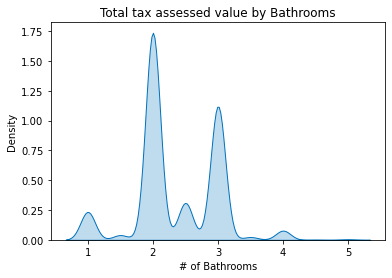

In [18]:
Mth = sns.kdeplot(train.bathrooms[(train["tax_value"] < 1000000) ],
                color="#0072BD", shade = True)
Mth.set_ylabel('Density')
Mth.set_xlabel('# of Bathrooms')
Mth.set_title('Total tax assessed value by Bathrooms')

#### Note: 2 - 3 bathrooms have highest tax value. Perhaps this is because that is how many baths a 3 or 4 bedroom has.

Text(0.5, 1.0, 'Total tax assessed value by Square Footage')

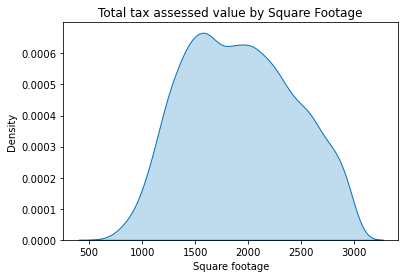

In [19]:
Mth = sns.kdeplot(train.square_feet[(train["tax_value"] < 1000000) ],
                color="#0072BD", shade = True)
Mth.set_ylabel('Density')
Mth.set_xlabel('Square footage')
Mth.set_title('Total tax assessed value by Square Footage')

#### Note: Between 1500 - 2000 square_feet have highest tax value.

## Modeling

#### Prepares data for Modeling

In [20]:
# Creates simple model based on bathrooms, bedrooms and square_feet. Compares against baseline(median tax value)
X_train = train[['bedrooms', 'bathrooms', 'square_feet']]
y_train = train[['tax_value']]
y_train['y_baseline'] = train['tax_value'].median()

# predictor/independent features split into train, test, validate
X_train = train.drop(columns = ['tax_value'],axis=1)
X_validate = validate.drop(columns = ['tax_value'],axis=1)
X_test = test.drop(columns = ['tax_value'],axis=1)

# target variables split into train, test, validate
# y_train = train.tax_value
y_validate = validate.tax_value
y_test = test.tax_value
y_train.head(3)

,tax_value,y_baseline
4192,875694,380351.5
20164,390727,380351.5
53874,508519,380351.5


In [21]:
# Calculates baseline (based on median) RMSE
rmse_baseline = sqrt(mean_squared_error(y_train.tax_value, y_train.y_baseline))
rmse_baseline

219730.81030193748

In [22]:
# Creates OLS model based on bathrooms, bedrooms, and square_feet
# generates parameters (creates model)
ols_model = ols('tax_value ~ bedrooms + bathrooms + square_feet', data = train).fit()

# computes predictions and add to original dataframe
y_train['yhat'] = ols_model.predict(X_train)
y_train.head(3)

,tax_value,y_baseline,yhat
4192,875694,380351.5,462715.794623
20164,390727,380351.5,514631.783768
53874,508519,380351.5,554272.688304


In [23]:
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              tax_value   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     331.7
Date:                Thu, 09 Jun 2022   Prob (F-statistic):          2.07e-198
Time:                        00:40:58   Log-Likelihood:                -77041.
No. Observations:                5652   AIC:                         1.541e+05
Df Residuals:                    5648   BIC:                         1.541e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1.594e+05   1.34e+04     11.864      0.000    1.33e+05    1.86e+05
bedrooms    -3.315e+04   4118.372     -8.049      0.000   -4.12e+04   -2.51e+04
bathrooms    1.343e+04   6087.582      2.206      0.027    1494.749    2.54e+04
square_feet   172.3902      7.672     22.471      0.000     157.351     187.430
==============================================================================
Omnibus:                      123.298   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              108.485
Skew:                           0.283   Prob(JB):                     2.77e-24
Kurtosis:                       2.624   Cond. No.                     1.02e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.02e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Note: My p-values are <0.05, I can reject my null hypothesis. Significant relationship between tax_values and the independent variables I used.

In [24]:
rmse = sqrt(mean_squared_error(y_train.tax_value, y_train.yhat))
rmse

201147.69679039976

### Note: RMSE for OLS (linear regression) model with bedrooom, bathroom and square feet 201147 < the baseline 219730.  R2 is 0.15 and p-value is 0.

In [25]:
# make a dataframe 'predictions' with actual tax_values
predictions = pd.DataFrame({
    'actual': y_train.tax_value
})
predictions.head()

,actual
4192,875694
20164,390727
53874,508519
16009,434917
1816,499307


In [26]:
X_train1 = X_train[['bedrooms', 'bathrooms', 'square_feet']]
y_train1 = y_train[['tax_value']]

In [27]:
#linear regression model
lm = LinearRegression()
# fit our train data on the model
lm.fit(X_train1, y_train1)
print("Linear Model:", lm)
print("intercept: ", lm.intercept_)
print("coefficients: ", lm.coef_)

Linear Model: LinearRegression()
intercept:  [159411.70440469]
coefficients:  [[-33150.00099701  13428.74706187    172.39021469]]


In [28]:
#predictions from linear regresssion model based on X_train independent variable values
predictions['yhat_lm'] = lm.predict(X_train1)
#Baseline predicted home value (median home price)
predictions['baseline'] = y_train.tax_value.median()
predictions.head(3)

,actual,yhat_lm,baseline
4192,875694,462715.794623,380351.5
20164,390727,514631.783769,380351.5
53874,508519,554272.688304,380351.5


In [29]:
# Use lamda and calculate RMSE for each columns in prediction dataframe
pd.options.display.float_format = '{:.3f}'.format
predictions.apply(lambda col: sqrt(mean_squared_error(predictions.actual, col)))

actual          0.000
yhat_lm    201147.697
baseline   219730.810
dtype: float64

In [30]:
rmse

201147.69679039976

In [31]:
rmse < rmse_baseline

True

#### Note: RMSE performs better than baseline

In [32]:
#using test data and predicting tax values based on linear model above
X_test = test[['bedrooms', 'bathrooms', 'square_feet']]
y_test = test[['tax_value']]
y_test['test_prediction'] = lm.predict(X_test)
y_test.rename(columns = {'tax_value': 'actual'}, inplace = True)
y_test.head()

,actual,test_prediction
22322,125461,410550.329
20147,271828,533473.397
25653,246268,501055.192
47236,145492,262674.904
14712,464798,444650.201


In [33]:
#Calculating RMSE for test predictions
y_test.apply(lambda col: sqrt(mean_squared_error(y_test.actual, col)))

actual                 0.000
test_prediction   195380.121
dtype: float64

In [34]:
#compare baseline
rmse_baseline

219730.81030193748

### RMSE for test data is lower than train data and shows LM is better than baseline.

### LassoLars Model

In [35]:
# create model object
lars = LassoLars(alpha=1.0)
# assign x_train/x_validate
x_train = train.drop(columns = ['tax_value','county','transaction_date'])
x_validate = validate.drop(columns = ['tax_value','county','transaction_date'])
# fit the model to our training data. Specify the column in y_train.
lars.fit(x_train, y_train['tax_value'])
# predict train
y_train['lars_train_pred'] = lars.predict(x_train)
# predict validate
y_validate['lars_validate_pred'] = lars.predict(x_validate)
y_train.head(3)

,tax_value,y_baseline,yhat,lars_train_pred
4192,875694,380351.500,462715.795,798435.898
20164,390727,380351.500,514631.784,388502.455
53874,508519,380351.500,554272.688,502921.228


### TweedieRegressor (GLM)

In [36]:
# create the model object
twr = TweedieRegressor()
# fit the model to our training data. Specify the column in y_train
twr.fit(x_train, y_train['tax_value'])
# predict train
y_train['twr_train_pred'] = twr.predict(x_train)
# predict validate
y_validate['twr_validate_pred'] = twr.predict(x_validate)
y_train.head(3)

,tax_value,y_baseline,yhat,lars_train_pred,twr_train_pred
4192,875694,380351.500,462715.795,798435.898,778412.618
20164,390727,380351.500,514631.784,388502.455,367006.310
53874,508519,380351.500,554272.688,502921.228,468590.258


# Conclusion

#### Identified drivers that affect total tax assessed value for property transactions in 2017 for Los Angeles, Orange, and Ventura counties.
    - found that square_footage, bedroom and bathroom count are drivers for market value of single unit properties.
    - LM performed better than baseline with drivers described above.
    - Los Angeles County has the highest tax rate of all three counties.
    
#### Note: If I had more time, I would explore additional features and compare findings to different years.